<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1">Imports</a></span></li><li><span><a href="#Data-pre-processing" data-toc-modified-id="Data-pre-processing-2">Data pre-processing</a></span></li><li><span><a href="#Function-definitions" data-toc-modified-id="Function-definitions-3">Function definitions</a></span></li><li><span><a href="#Gradient-Boosted-Trees" data-toc-modified-id="Gradient-Boosted-Trees-4">Gradient Boosted Trees</a></span></li><li><span><a href="#HistGradientBoostingClassifier" data-toc-modified-id="HistGradientBoostingClassifier-5">HistGradientBoostingClassifier</a></span></li><li><span><a href="#Class-weights" data-toc-modified-id="Class-weights-6">Class weights</a></span></li><li><span><a href="#Initial-Classifiers" data-toc-modified-id="Initial-Classifiers-7">Initial Classifiers</a></span><ul class="toc-item"><li><span><a href="#Important-features" data-toc-modified-id="Important-features-7.1">Important features</a></span><ul class="toc-item"><li><span><a href="#Hyperparameter-tuning" data-toc-modified-id="Hyperparameter-tuning-7.1.1">Hyperparameter tuning</a></span></li><li><span><a href="#Including-the-V***-columns" data-toc-modified-id="Including-the-V***-columns-7.1.2">Including the V*** columns</a></span></li><li><span><a href="#Only-features-deemed-important-by-RF-model-interpretation-with-V***-features" data-toc-modified-id="Only-features-deemed-important-by-RF-model-interpretation-with-V***-features-7.1.3">Only features deemed important by RF model interpretation with V*** features</a></span></li><li><span><a href="#Only-features-deemed-important-by-RF-model-interpretation" data-toc-modified-id="Only-features-deemed-important-by-RF-model-interpretation-7.1.4">Only features deemed important by RF model interpretation</a></span></li></ul></li></ul></li></ul></div>

# Imports

In [1]:
from fastai.tabular.all import *
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
import seaborn as sn


from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier

path = Path('/Users/baranserajelahi/Codes/fraud-detection-pytorch-scikit-fastai/data')
Path.BASE_PATH = path
pd.options.display.max_rows = 200
pd.options.display.max_columns = 125

# Data pre-processing

In [2]:
# Tabular object created and saved on the 02_ notebook
to = (path/'to_ss.pkl').load()

In [3]:
to["card1"].dtype

dtype('int16')

In [4]:
cats = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
       'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 
       'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 
       'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 
       'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38']

for cat in cats:
    to[cat] = to[cat].astype('category')

In [5]:
to["card1"].dtype

CategoricalDtype(categories=[   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
                  ...
                  5646, 5647, 5648, 5649, 5650, 5651, 5652, 5653, 5654, 5655],
                 ordered=False)

In [6]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [7]:
xs.shape, valid_xs.shape, valid_y.sum(), valid_y.mean()

((48491, 122), (10563, 122), 359, 0.03398655684937991)

# Function definitions

In [8]:
def fit(m, xs=xs, y=y, valid_xs=valid_xs, valid_y=valid_y, **kwargs):
    m.fit(xs, y, **kwargs)
    prob_train = m.predict_proba(xs)[:,1]
    pred_train = m.predict(xs)
    prob_valid = m.predict_proba(valid_xs)[:,1]
    pred_valid = m.predict(valid_xs)
    Train_AROC = roc_auc_score(y, prob_train )
    Valid_AROC = roc_auc_score(valid_y, prob_valid)
    print(f'Train_AROC: {Train_AROC}')
    print(f'Valid_AROC: {Valid_AROC}')
    return prob_train, pred_train, prob_valid, pred_valid

In [9]:
def metrics(y_true, y_pred, y_prob, acc=False):
    # calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    P, R, F1, _  = precision_recall_fscore_support(y_true, y_pred, beta=1.0)
    _, _, F2, _  = precision_recall_fscore_support(y_true, y_pred, beta=2.0)
    _, _, F5, _  = precision_recall_fscore_support(y_true, y_pred, beta=5.0)
    _, _, F10, _ = precision_recall_fscore_support(y_true, y_pred, beta=10.0)
    AROC         = roc_auc_score(y_true, y_prob)
    APRC         = auc(recall, precision)
    if acc==True:
        cm = confusion_matrix(y_true, y_pred)
        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)
        ACC = (TP+TN)/(TP+FP+FN+TN)
    print(f'AROC: {AROC}')  
    print(f'APRC: {APRC}')
    print(f'Percision: {P[1]}')
    print(f'Recall: {R[1]}')
    if acc==True:
        print(f'ACC: {ACC[1]}')
    print(f'F1: {F1[1]}')
    print(f'F2: {F2[1]}')
    print(f'F5: {F5[1]}')
    print(f'F10: {F10[1]}')
    return P[1], R[1], F1[1], F2[1], F5[1], F10[1] 

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    # calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = ['legit', 'Fraud']
    fig = plt.figure()
    #ax = fig.add_subplot(111)
    df_cm = pd.DataFrame(cm, range(len(cm)), range(len(cm)))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.0f') # font size
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return fig

In [11]:
def plot_roc_prc(y_true, y_prob, fig_size=(11,5), label=None):
    fig, ax = plt.subplots(1,2, figsize=fig_size)    

# precision-recall curve
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y_true[y_true==1]) / len(y_true)
    # calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    # plot the no skill precision-recall curve
    ax[0].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot the precision-recall curve
    if label!=None:
        ax[0].plot(recall, precision, marker='.', label=label)
    else:
        ax[0].plot(recall, precision, marker='.')
    # axis labels
    ax[0].set(xlabel='Precision', ylabel='Recall')
    # show the legend
    ax[0].legend()

# roc curve
    # plot no skill roc curve
    ax[1].plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    # calculate roc curve 
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    # plot roc curve
    if label!=None:
        ax[1].plot(fpr, tpr, marker='.', label=label)
    else:
        ax[1].plot(fpr, tpr, marker='.')
    # axis labels
    ax[1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    # show the legend
    ax[1].legend()
    return fig

# HistGradientBoostingClassifier

In [112]:
'Previously, leaf-wise growth was an exclusive feature of lightGBM, but xgboost has since implemented this growth strategy (this change has not been reflected in the lightGBM docs, but has been acknowledged in a blog post). This strategy is only available for the histogram-based method (which I will explain below), so in order to use it, users will have to set the tree_method parameter to hist and the grow_policy parameter to lossguide.'

'Previously, leaf-wise growth was an exclusive feature of lightGBM, but xgboost has since implemented this growth strategy (this change has not been reflected in the lightGBM docs, but has been acknowledged in a blog post). This strategy is only available for the histogram-based method (which I will explain below), so in order to use it, users will have to set the tree_method parameter to hist and the grow_policy parameter to lossguide.'

In [113]:
'Xgboost offers the option tree_method=approx, which computes a new set of bins at each split using the gradient statistics. LightGBM and xgboost with the tree_method set to hist will both compute the bins at the beginning of training and reuse the same bins throughout the entire training process.'

'Xgboost offers the option tree_method=approx, which computes a new set of bins at each split using the gradient statistics. LightGBM and xgboost with the tree_method set to hist will both compute the bins at the beginning of training and reuse the same bins throughout the entire training process.'

In [114]:
'BOTH: Though lightGBM does not enable ignoring zero values by default, it has an option called zero_as_missing which, if set to True, will regard all zero values as missing. According to this thread on GitHub, lightGBM will treat missing values in the same way as xgboost as long as the parameter use_missing is set to True (which is the default behavior).'

'Though lightGBM does not enable ignoring zero values by default, it has an option called zero_as_missing which, if set to True, will regard all zero values as missing. According to this thread on GitHub, lightGBM will treat missing values in the same way as xgboost as long as the parameter use_missing is set to True (which is the default behavior).'

In [115]:
'LGBM: This is a method introduced in lightGBM that also takes advantage of the sparsity of large datasets. The essential observation behind this method is that the sparsity of features means that some features are never non-zero together. For instance, the words "Python" and "protein" might never appear in the same document in the data. This means that these features can be "bundled" into a single feature without losing any information. Suppose the tf-idf score for "Python" ranges from 0 to 10 and the tf-idf score for  "protein" ranges from 0 to 20. In this case, the feature'

'This is a method introduced in lightGBM that also takes advantage of the sparsity of large datasets. The essential observation behind this method is that the sparsity of features means that some features are never non-zero together. For instance, the words "Python" and "protein" might never appear in the same document in the data. This means that these features can be "bundled" into a single feature without losing any information. Suppose the tf-idf score for "Python" ranges from 0 to 10 and the tf-idf score for  "protein" ranges from 0 to 20. In this case, the feature'

In [116]:
'LGBM: Unfortunately, the problem of finding the most efficient bundle is NP-hard. Therefore, the authors of the paper opted for an approximate algorithm that tolerated a certain degree of overlap \gamma  between the non-zero elements within a feature bundle. The details of this algorithm are beyond the scope of this post, so please refer to the original paper for details.'

'Unfortunately, the problem of finding the most efficient bundle is NP-hard. Therefore, the authors of the paper opted for an approximate algorithm that tolerated a certain degree of overlap \\gamma  between the non-zero elements within a feature bundle. The details of this algorithm are beyond the scope of this post, so please refer to the original paper for details.'

HistGradientBoostingClassifier is based on Microsofts LightGBM.

# Class weights

In [12]:
df = pd.read_csv(path/'train_ss.csv', index_col=[0])

In [13]:
class_count_df = df.groupby('isFraud').count()['TransactionID']

n_0, n_1 = class_count_df[0], class_count_df[1]

w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)
weights = [w_0, w_1]

In [14]:
sample_weight = [w_0 if y==0 else w_1 for y in y]

In [15]:
assert len(sample_weight)==len(xs)

# Initial Classifiers 

The max_iter parameter is increased to 1000 from its default value of 100.

In [84]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc')
_, _, prob_valid, pred_valid = fit(m);

Binning 0.043 GB of training data: 0.277 s
Binning 0.005 GB of validation data: 0.019 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.81449, val score: 0.77062, in 0.044s
[2/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.85231, val score: 0.78618, in 0.045s
[3/1000] 1 tree, 31 leaves, max depth = 14, train score: 0.85744, val score: 0.79733, in 0.055s
[4/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.86731, val score: 0.81684, in 0.048s
[5/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.87011, val score: 0.81532, in 0.046s
[6/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.88030, val score: 0.83093, in 0.046s
[7/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.88448, val score: 0.82872, in 0.048s
[8/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.88594, val score: 0.83017, in 0.047s
[9/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.89521, val score: 0.83428, in 0.048s
[10/1000] 1 tree, 31

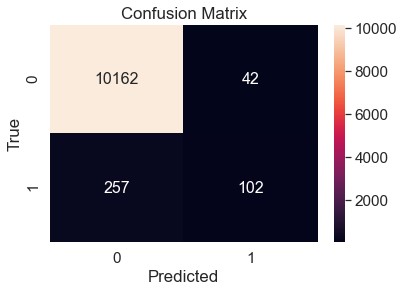

In [87]:
fig = plot_confusion_matrix(valid_y, pred_valid)
fig.savefig(path.BASE_PATH/'../figures/Initial_HistGBC_Confusion_Matrix.jpg', dpi=1000, bbox_inches='tight')

In [88]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8660519005600512
APRC: 0.4083374076646119
Percision: 0.7083333333333334
Recall: 0.2841225626740947
ACC: 0.9716936476379816
F1: 0.4055666003976143
F2: 0.3227848101265823
F5: 0.2908213619914464
F10: 0.28581733436910434


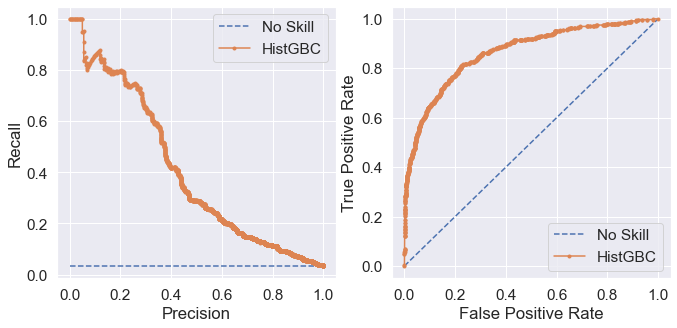

In [89]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')
fig.savefig(path.BASE_PATH/'../figures/Initial_HistGBC_aucs.jpg', dpi=1000, bbox_inches='tight')

In [90]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc')
_, _, prob_valid, pred_valid = fit(m, sample_weight=sample_weight);

Binning 0.043 GB of training data: 0.276 s
Binning 0.005 GB of validation data: 0.020 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.87630, val score: 0.81379, in 0.049s
[2/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.89470, val score: 0.83953, in 0.047s
[3/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.89517, val score: 0.84486, in 0.051s
[4/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.89837, val score: 0.84677, in 0.054s
[5/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.89925, val score: 0.84526, in 0.050s
[6/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.90203, val score: 0.85097, in 0.051s
[7/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.90342, val score: 0.85385, in 0.053s
[8/1000] 1 tree, 31 leaves, max depth = 14, train score: 0.90684, val score: 0.85497, in 0.049s
[9/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.90753, val score: 0.85529, in 0.049s
[10/1000] 1 tree, 31 

[85/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.98392, val score: 0.88946, in 0.068s
[86/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.98408, val score: 0.88981, in 0.076s
[87/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.98437, val score: 0.89036, in 0.065s
[88/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.98473, val score: 0.89065, in 0.064s
[89/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.98497, val score: 0.89104, in 0.064s
[90/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.98538, val score: 0.89135, in 0.063s
[91/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.98560, val score: 0.89132, in 0.064s
[92/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.98589, val score: 0.89139, in 0.067s
[93/1000] 1 tree, 31 leaves, max depth = 7, train score: 0.98621, val score: 0.89031, in 0.065s
[94/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.98645, val score: 0.89062, in 0.062s
[95/1000] 1 tree, 31 leaves, max de

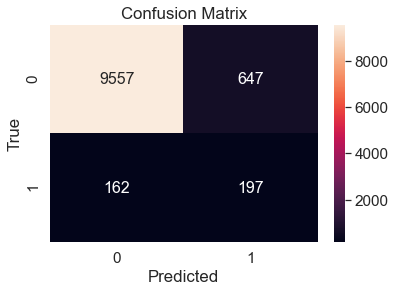

In [91]:
fig = plot_confusion_matrix(valid_y, pred_valid)
fig.savefig(path.BASE_PATH/'../figures/Initial_weighted_HistGBC_Confusion_Matrix.jpg', dpi=1000, bbox_inches='tight')

In [76]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8730040870967635
APRC: 0.40186301721976925
Percision: 0.19928507596067918
Recall: 0.6211699164345403
ACC: 0.9023004828173814
F1: 0.3017591339648173
F2: 0.43639921722113506
F5: 0.5744006340400236
F10: 0.6084172992247225


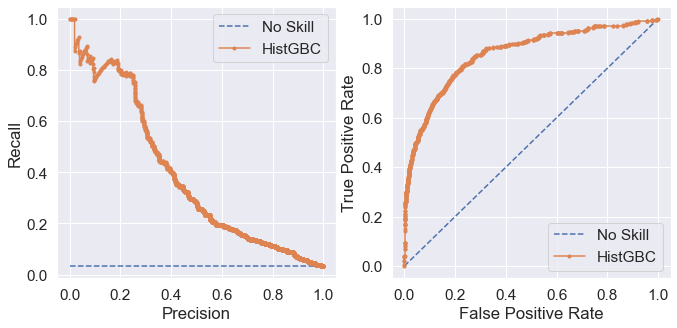

In [92]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')
fig.savefig(path.BASE_PATH/'../figures/Initial_weighted_HistGBC_aucs.jpg', dpi=1000, bbox_inches='tight')

In [93]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1, l2_regularization=2.4,
                             learning_rate=0.03, max_depth=25, max_iter=1000, max_leaf_nodes=44,
                             min_samples_leaf=8,  scoring='roc_auc', tol=1e-8)
_, _, prob_valid, pred_valid = fit(m);

Binning 0.043 GB of training data: 0.273 s
Binning 0.005 GB of validation data: 0.019 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.84546, val score: 0.80071, in 0.058s
[2/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.84871, val score: 0.80490, in 0.054s
[3/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.85411, val score: 0.80836, in 0.056s
[4/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.85342, val score: 0.81808, in 0.054s
[5/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.85369, val score: 0.81905, in 0.056s
[6/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.86189, val score: 0.82214, in 0.057s
[7/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.86168, val score: 0.82246, in 0.055s
[8/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.86328, val score: 0.82233, in 0.057s
[9/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.87178, val score: 0.83703, in 0.061s
[10/1000] 1 tre

[85/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.93348, val score: 0.87392, in 0.083s
[86/1000] 1 tree, 44 leaves, max depth = 17, train score: 0.93417, val score: 0.87385, in 0.085s
[87/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.93477, val score: 0.87452, in 0.079s
[88/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.93546, val score: 0.87426, in 0.163s
[89/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.93593, val score: 0.87463, in 0.096s
[90/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.93674, val score: 0.87516, in 0.100s
[91/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.93721, val score: 0.87560, in 0.097s
[92/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.93803, val score: 0.87641, in 0.106s
[93/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.93846, val score: 0.87636, in 0.094s
[94/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.93889, val score: 0.87643, in 0.090s
[95/1000] 1 tree, 44 leaves, m

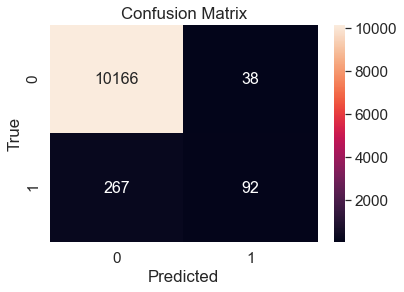

In [94]:
fig = plot_confusion_matrix(valid_y, pred_valid)
fig.savefig(path.BASE_PATH/'../figures/RFparams_HistGBC_Confusion_Matrix.jpg', dpi=1000, bbox_inches='tight')

In [95]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8797418457342087
APRC: 0.44099723308972494
Percision: 0.7076923076923077
Recall: 0.2562674094707521
ACC: 0.9711256271892454
F1: 0.37627811860940696
F2: 0.29374201787994897
F5: 0.26271279516749046
F10: 0.25789619761310023


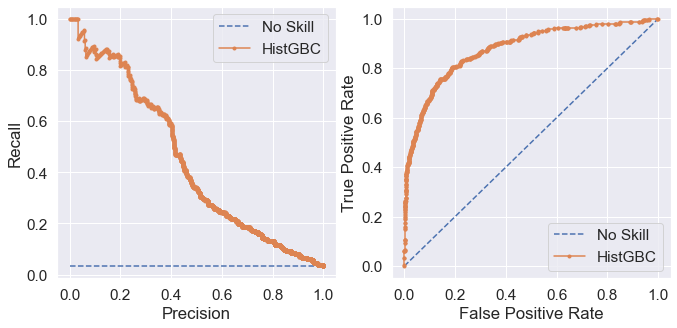

In [96]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')
fig.savefig(path.BASE_PATH/'../figures/RFparams_HistGBC_aucs.jpg', dpi=1000, bbox_inches='tight')

In [101]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1, l2_regularization=2.4,
                             learning_rate=0.03, max_depth=25, max_iter=1000, max_leaf_nodes=44,
                             min_samples_leaf=8,  scoring='roc_auc', tol=1e-8)
_, _, prob_valid, pred_valid = fit(m, sample_weight=sample_weight);

Binning 0.043 GB of training data: 0.271 s
Binning 0.005 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.85357, val score: 0.82605, in 0.062s
[2/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.85637, val score: 0.82490, in 0.058s
[3/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.86082, val score: 0.83225, in 0.057s
[4/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.86290, val score: 0.83481, in 0.060s
[5/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.86369, val score: 0.83614, in 0.081s
[6/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.86762, val score: 0.83806, in 0.080s
[7/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.87002, val score: 0.83971, in 0.107s
[8/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.87181, val score: 0.84132, in 0.099s
[9/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.87750, val score: 0.84234, in 0.078s
[10/1000] 1 tre

[85/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.94139, val score: 0.88258, in 0.080s
[86/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.94189, val score: 0.88274, in 0.093s
[87/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.94247, val score: 0.88303, in 0.076s
[88/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.94308, val score: 0.88323, in 0.134s
[89/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.94363, val score: 0.88314, in 0.075s
[90/1000] 1 tree, 44 leaves, max depth = 16, train score: 0.94442, val score: 0.88339, in 0.078s
[91/1000] 1 tree, 44 leaves, max depth = 16, train score: 0.94494, val score: 0.88301, in 0.078s
[92/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.94557, val score: 0.88332, in 0.077s
[93/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.94611, val score: 0.88341, in 0.078s
[94/1000] 1 tree, 44 leaves, max depth = 17, train score: 0.94658, val score: 0.88354, in 0.081s
[95/1000] 1 tree, 44 leaves, m

[169/1000] 1 tree, 44 leaves, max depth = 18, train score: 0.97384, val score: 0.89321, in 0.095s
[170/1000] 1 tree, 44 leaves, max depth = 20, train score: 0.97413, val score: 0.89285, in 0.101s
[171/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.97434, val score: 0.89299, in 0.114s
[172/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.97452, val score: 0.89316, in 0.113s
[173/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.97472, val score: 0.89321, in 0.113s
[174/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.97490, val score: 0.89315, in 0.192s
[175/1000] 1 tree, 44 leaves, max depth = 19, train score: 0.97511, val score: 0.89316, in 0.113s
[176/1000] 1 tree, 44 leaves, max depth = 19, train score: 0.97531, val score: 0.89332, in 0.150s
[177/1000] 1 tree, 44 leaves, max depth = 19, train score: 0.97552, val score: 0.89324, in 0.125s
[178/1000] 1 tree, 44 leaves, max depth = 19, train score: 0.97576, val score: 0.89366, in 0.122s
[179/1000] 1 tree, 4

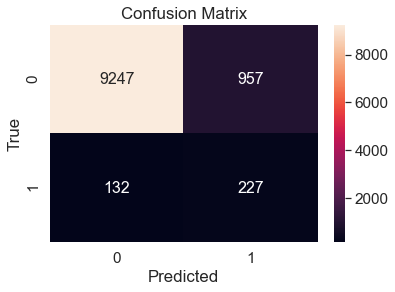

In [102]:
fig = plot_confusion_matrix(valid_y, pred_valid)
fig.savefig(path.BASE_PATH/'../figures/RFparams_weighted_HistGBC_Confusion_Matrix.jpg', dpi=1000, bbox_inches='tight')

In [103]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8682888571743671
APRC: 0.41337335727015256
Percision: 0.19172297297297297
Recall: 0.6323119777158774
ACC: 0.896904288554388
F1: 0.2942320155541154
F2: 0.43320610687022904
F5: 0.5809626931784624
F10: 0.6182450652572539


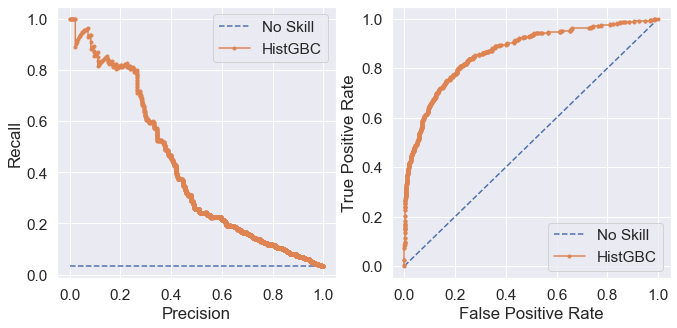

In [104]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')
fig.savefig(path.BASE_PATH/'../figures/RFparams_weighted_HistGBC_aucs.jpg', dpi=1000, bbox_inches='tight')

## Important features

In [29]:
xs_imp = (path/'xs_imp.pkl').load()
valid_xs_imp = (path/'valid_xs_imp.pkl').load()

In [30]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1, l2_regularization=2.4,
                             learning_rate=0.03, max_depth=25, max_iter=1000, max_leaf_nodes=44,
                             min_samples_leaf=8,  scoring='roc_auc', tol=1e-8)
_, _, baseline_prob, baseline_pred = fit(m)

Binning 0.043 GB of training data: 0.282 s
Binning 0.005 GB of validation data: 0.019 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.84197, val score: 0.81636, in 0.074s
[2/1000] 1 tree, 44 leaves, max depth = 9, train score: 0.85760, val score: 0.82561, in 0.089s
[3/1000] 1 tree, 44 leaves, max depth = 9, train score: 0.86092, val score: 0.83184, in 0.085s
[4/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.86408, val score: 0.84166, in 0.096s
[5/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.86431, val score: 0.84492, in 0.091s
[6/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.86367, val score: 0.84541, in 0.134s
[7/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.86399, val score: 0.84544, in 0.066s
[8/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.86431, val score: 0.84450, in 0.061s
[9/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.86491, val score: 0.84601, in 0.068s
[10/1000] 1 tree,

[85/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.93089, val score: 0.89297, in 0.095s
[86/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.93139, val score: 0.89314, in 0.145s
[87/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.93194, val score: 0.89339, in 0.115s
[88/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.93217, val score: 0.89315, in 0.095s
[89/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.93249, val score: 0.89329, in 0.093s
[90/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.93325, val score: 0.89366, in 0.095s
[91/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.93389, val score: 0.89398, in 0.094s
[92/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.93419, val score: 0.89450, in 0.096s
[93/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.93494, val score: 0.89477, in 0.168s
[94/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.93572, val score: 0.89542, in 0.097s
[95/1000] 1 tree, 44 leaves, m

### Hyperparameter tuning

Hyperparameters were tuned interatively using GridSearchCV. Only the final results are displayed in the notenbook.

To speed up the grid search let's randomly sample 10% of our data (which is already a simple random sample of 10% of the original dataset).

In [24]:
xs_imp.shape, y.shape, valid_xs_imp.shape, valid_y.shape

((48491, 61), (48491,), (10563, 61), (10563,))

In [75]:
parameters1 = {
 'max_depth': [15],
 'random_state': [33],
 }

In [93]:
parameters2 = {
 'max_depth': [15],
 'learning_rate': [0.1],
 'random_state': [33],
 }

In [132]:
parameters3 = {
 'max_depth': [15],
 'learning_rate': [0.1], 
 'l2_regularization': [4.0],
 'random_state': [33],
 }

In [149]:
parameters4 = {
 'max_depth': [15],
 'learning_rate': [0.1], 
 'l2_regularization': [4.0],
 'min_samples_leaf': [20],
 'random_state': [33],
 }

In [159]:
parameters5 = {
 'max_depth': [15],
 'learning_rate': [0.1], 
 'l2_regularization': [4.0],
 'min_samples_leaf': [20],
 'max_leaf_nodes': [31],
 'random_state': [33],
 }

In [175]:
parameters6 = {
 'max_depth': [15],
 'learning_rate': [0.1], 
 'l2_regularization': [4.0],
 'min_samples_leaf': [20],
 'max_leaf_nodes': [31],
 'tol': [1e-8]
 'random_state': [33],
 }

In [176]:
clf = GridSearchCV(HistGradientBoostingClassifier(loss='binary_crossentropy', max_iter=1000, 
                                                  scoring='roc_auc', tol=1e-8), parameters6, 
                   scoring=make_scorer(roc_auc_score, needs_proba=True), n_jobs=-1, cv=3,
                   verbose=3)

In [177]:
%%time
clf.fit(xs, y)
clf.best_estimator_, clf.best_score_, clf.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:  2.6min remaining: 12.8min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  4.7min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.9min finished


CPU times: user 3min 45s, sys: 1min 27s, total: 5min 13s
Wall time: 6min 48s


(HistGradientBoostingClassifier(l2_regularization=4.0,
                                loss='binary_crossentropy', max_depth=15,
                                max_iter=1000, random_state=33,
                                scoring='roc_auc', tol=1e-08),
 0.8963061409318414,
 {'l2_regularization': 4.0,
  'learning_rate': 0.1,
  'max_depth': 15,
  'max_leaf_nodes': 31,
  'min_samples_leaf': 20,
  'random_state': 33,
  'tol': 1e-08})

In [25]:
%%time
clf = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc',
                                    max_depth=15, learning_rate=0.1,
                                    l2_regularization=4.0)
clf.fit(xs,y)
m_roc(y, xs), m_roc(valid_y, valid_xs)

Binning 0.043 GB of training data: 0.289 s
Binning 0.005 GB of validation data: 0.029 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.82933, val score: 0.82698, in 0.062s
[2/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.84590, val score: 0.85051, in 0.067s
[3/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.84719, val score: 0.85282, in 0.066s
[4/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.85027, val score: 0.85531, in 0.069s
[5/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.86926, val score: 0.87443, in 0.068s
[6/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.87274, val score: 0.87438, in 0.069s
[7/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.87440, val score: 0.87288, in 0.073s
[8/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.88008, val score: 0.88139, in 0.073s
[9/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.88726, val score: 0.88774, in 0.097s
[10/1000] 1 tree, 31

[85/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.96003, val score: 0.91114, in 0.101s
Fit 85 trees in 8.482 s, (2635 total leaves)
Time spent computing histograms: 3.120s
Time spent finding best splits:  0.869s
Time spent applying splits:      1.059s
Time spent predicting:           0.018s
CPU times: user 49.5 s, sys: 8.11 s, total: 57.6 s
Wall time: 8.75 s


(0.9594442623062389, 0.8774343230957548)

### Including the V*** columns

In [194]:
to = (path/'to_full.pkl').load()

xs, y             = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [195]:
cats = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
       'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 
       'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 
       'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 
       'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38']

for cat in cats:
    to[cat] = to[cat].astype('category')

In [196]:
%%time
clf = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc',
                                    max_depth=15, learning_rate=0.1,
                                    l2_regularization=4.0, tol=1e-8)
clf.fit(xs,y)
m_roc(y, xs), m_roc(valid_y, valid_xs)

Binning 0.279 GB of training data: 1.745 s
Binning 0.031 GB of validation data: 0.042 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.84101, val score: 0.85701, in 0.156s
[2/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.86369, val score: 0.87599, in 0.177s
[3/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.86724, val score: 0.87988, in 0.157s
[4/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.87065, val score: 0.88631, in 0.183s
[5/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.87563, val score: 0.89064, in 0.162s
[6/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.87965, val score: 0.89242, in 0.225s
[7/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.88089, val score: 0.89431, in 0.253s
[8/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.88305, val score: 0.89610, in 0.255s
[9/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.88634, val score: 0.89780, in 0.227s
[10/1000] 1 tree, 31

[85/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.95748, val score: 0.92662, in 0.304s
[86/1000] 1 tree, 31 leaves, max depth = 13, train score: 0.95765, val score: 0.92687, in 0.312s
[87/1000] 1 tree, 31 leaves, max depth = 15, train score: 0.95855, val score: 0.92688, in 0.317s
[88/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.95911, val score: 0.92699, in 0.492s
[89/1000] 1 tree, 31 leaves, max depth = 15, train score: 0.95927, val score: 0.92696, in 0.580s
[90/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.95956, val score: 0.92701, in 0.340s
[91/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.96012, val score: 0.92770, in 0.353s
[92/1000] 1 tree, 31 leaves, max depth = 14, train score: 0.96034, val score: 0.92785, in 0.309s
[93/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.96072, val score: 0.92811, in 0.507s
[94/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.96092, val score: 0.92817, in 0.518s
[95/1000] 1 tree, 31 leaves, max

(0.9662431693097167, 0.8943595769682725)

### Only features deemed important by RF model interpretation with V*** features

In [205]:
xs_imp = (path/'xs_imp_full.pkl').load()
valid_xs_imp = (path/'valid_xs_imp_full.pkl').load()

In [206]:
%%time
clf = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc',
                                    max_depth=15, learning_rate=0.1,
                                    l2_regularization=4.0, tol=1e-8)
clf.fit(xs_imp,y)
m_roc(y, xs_imp), m_roc(valid_y, valid_xs_imp)

Binning 0.011 GB of training data: 0.114 s
Binning 0.001 GB of validation data: 0.006 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.85183, val score: 0.82808, in 0.034s
[2/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.85846, val score: 0.83773, in 0.034s
[3/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.86037, val score: 0.84088, in 0.033s
[4/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.86785, val score: 0.85493, in 0.035s
[5/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.86885, val score: 0.85801, in 0.052s
[6/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.87304, val score: 0.85900, in 0.032s
[7/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.87515, val score: 0.86176, in 0.032s
[8/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.87517, val score: 0.86165, in 0.025s
[9/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.87960, val score: 0.86407, in 0.042s
[10/1000] 1 tree, 3

(0.9433326003871689, 0.8825521657999629)

### Only features deemed important by RF model interpretation

In [26]:
xs_imp = (path/'xs_imp.pkl').load()
valid_xs_imp = (path/'valid_xs_imp.pkl').load()

In [29]:
%%time
clf = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc',
                                    max_depth=15, learning_rate=0.1,
                                    l2_regularization=4.0, tol=1e-8)
clf.fit(xs_imp,y)
m_roc(y, xs_imp), m_roc(valid_y, valid_xs_imp)

Binning 0.021 GB of training data: 0.175 s
Binning 0.002 GB of validation data: 0.014 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.83554, val score: 0.84848, in 0.066s
[2/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.86201, val score: 0.86134, in 0.057s
[3/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.86932, val score: 0.85516, in 0.054s
[4/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.87211, val score: 0.85237, in 0.064s
[5/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.87514, val score: 0.86356, in 0.062s
[6/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.87806, val score: 0.86451, in 0.062s
[7/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.88273, val score: 0.87102, in 0.058s
[8/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.88680, val score: 0.87063, in 0.063s
[9/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.88888, val score: 0.87139, in 0.064s
[10/1000] 1 tree, 3

[85/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.96862, val score: 0.89220, in 0.090s
[86/1000] 1 tree, 31 leaves, max depth = 13, train score: 0.96893, val score: 0.89226, in 0.091s
[87/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.96921, val score: 0.89290, in 0.097s
[88/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.96945, val score: 0.89278, in 0.088s
[89/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.96964, val score: 0.89237, in 0.097s
[90/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.97007, val score: 0.89279, in 0.094s
[91/1000] 1 tree, 31 leaves, max depth = 13, train score: 0.97036, val score: 0.89320, in 0.090s
[92/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.97051, val score: 0.89343, in 0.087s
[93/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.97072, val score: 0.89323, in 0.087s
[94/1000] 1 tree, 31 leaves, max depth = 14, train score: 0.97110, val score: 0.89335, in 0.088s
[95/1000] 1 tree, 31 leaves, max d

(0.9687158661985884, 0.8810013878439718)

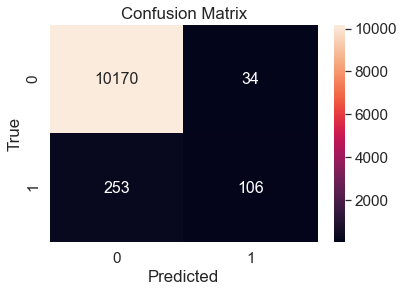

In [35]:
fig = plot_confusion_matrix(valid_y, clf.predict(valid_xs_imp))
fig.savefig(path.BASE_PATH/'../figures/GBT_imp_Confusion_Matrix.jpg', dpi=1000, bbox_inches='tight')